In [17]:
!pip3 install statsmodels
# !pip3 uninstall statsmodels -y
!pip3 install pmdarima

from IPython.display import clear_output
from pmdarima.arima import auto_arima
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import math
from sklearn.metrics import mean_squared_error as mse


clear_output()

In [2]:
# connect to google drive
in_colab = False
try:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir("/content/drive/MyDrive/Capstone/Project_1")  
    in_colab = True
except:
    pass

Mounted at /content/drive


In [3]:
# Load Data

gdp_df = pd.read_excel("Data/GDP_quarterly_data.xlsx")
gdp_df = gdp_df.drop(['Unnamed: 0'], axis =1)

cpi_df = pd.read_excel("Data/CPI_Monthly_Change.xlsx")
cpi_df = cpi_df.drop(['Unnamed: 0'], axis =1)

cpi_df = cpi_df[1:].reset_index(drop=True) # drop first row - doesn't have a previous month to calculate change

In [4]:
gdp_df.head()

,Year,Gross domestic product,Personal consumption expenditures,Goods,Durable goods,Nondurable goods,Services,Gross private domestic investment,Fixed investment,Nonresidential,...,Services.1,Imports,Goods.2,Services.2,Government consumption expenditures and gross investment,Federal,National defense,Nondefense,State and local,CPI
0,1947Q2,-1.1,6.8,7.4,8.7,7.0,5.9,-27.3,-10.0,-6.1,...,38.3,7.9,9.4,3.4,-0.4,-3.3,-25.2,224.5,5.7,21.933333
1,1947Q3,-0.8,1.3,2.7,5.6,1.9,-0.8,-11.3,13.6,-7.2,...,-8.4,-38.2,-43.9,-14.8,-0.1,-5.0,11.2,-48.5,9.4,22.566667
2,1947Q4,6.4,0.1,1.5,28.6,-5.1,-2.1,102.9,37.2,11.6,...,-17.2,23.5,5.5,98.0,-3.2,-8.6,8.9,-58.5,6.4,23.166667
3,1948Q1,6.2,2.0,0.6,-2.0,1.3,4.3,47.8,13.4,25.3,...,-25.5,61.6,86.5,5.7,6.1,10.4,-4.5,113.2,-0.9,23.533333
4,1948Q2,6.8,4.7,3.7,2.7,4.0,6.4,27.1,-0.6,-12.7,...,-18.6,16.8,16.5,17.3,14.9,16.9,-8.7,200.7,11.4,23.933333


In [5]:
cpi_df.head()

,TimeStamp,CPI,Prev_CPI,Change
0,1913-Feb,9.8,9.8,0.0
1,1913-Mar,9.8,9.8,0.0
2,1913-Apr,9.8,9.8,0.0
3,1913-May,9.7,9.8,-0.1
4,1913-June,9.8,9.7,0.1


## Gross Domestic Product

### Evaluate Autocorrelation of Dependent Variable

/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


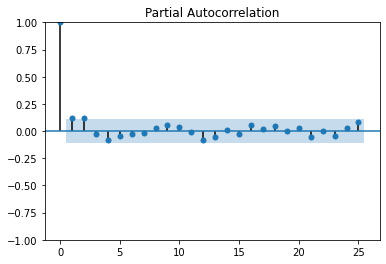

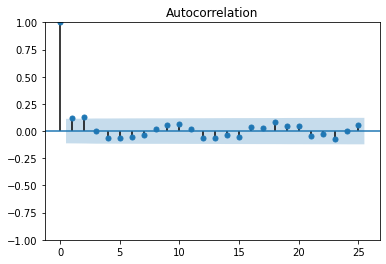

In [6]:
# https://vitalflux.com/autoregressive-ar-models-with-python-examples/
# https://www.youtube.com/watch?v=lPvIkGZjbZk

# Load AutoReg class from statsmodels.tsa.ar_model module
#
from statsmodels.tsa.ar_model import AutoReg

# find the order of AR model to be trained
# for this, we will plot partial autocorrelation plot to assess
# the direct effect of past data on future data

from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

pacf = plot_pacf(gdp_df['Gross domestic product'], lags=25)
acf = plot_acf(gdp_df['Gross domestic product'], lags=25)

In [7]:
# Specify size of training set

num_gdp_timepoints = len(gdp_df)
gdp_training_size = int(num_gdp_timepoints * 0.99)
gdp_training = gdp_df[:gdp_training_size]
gdp_testing = gdp_df[gdp_training_size:]

print(f"Total number of GDP Timepoints: {num_gdp_timepoints}")
print(f"Training Timepoints: {gdp_training_size}")
print(f"Testing Timepoints: {len(gdp_df) - gdp_training_size}")

# Predict 4 quarters in advance

Total number of GDP Timepoints: 303
Training Timepoints: 299
Testing Timepoints: 4


## ARCH Model

In [9]:
!pip install arch
from arch import arch_model
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
import warnings
warnings.filterwarnings("ignore")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 907.3/907.3 KB 19.1 MB/s eta 0:00:00


In [ ]:
# https://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016#AR
# https://bashtage.github.io/arch/univariate/introduction.html

def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

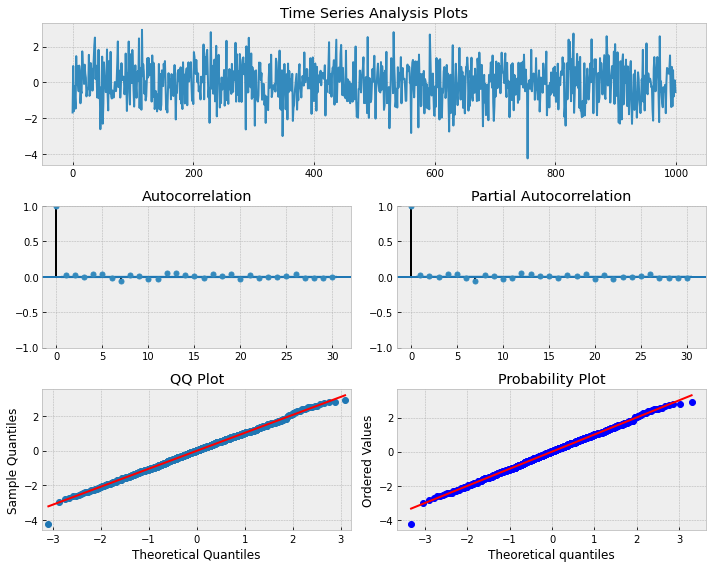

In [ ]:
randser = np.random.normal(size=1000)
tsplot(randser, lags=30)

In [10]:
gdp_training['Gross domestic product'].min()

-29.9

In [11]:
gdp_arch_model = arch_model(gdp_training['Gross domestic product'], vol='arch', p=5, q=5, o=5)
gdp_arch_model_results = gdp_arch_model.fit(update_freq=5)
print(gdp_arch_model_results.summary())

Iteration:      5,   Func. Count:     46,   Neg. LLF: 828.49958012206
Iteration:     10,   Func. Count:     91,   Neg. LLF: 831.9899628056817
Iteration:     15,   Func. Count:    134,   Neg. LLF: 826.3089668920775
Optimization terminated successfully    (Exit mode 0)
            Current function value: 826.3089654039131
            Iterations: 17
            Function evaluations: 149
            Gradient evaluations: 17
                        Constant Mean - ARCH Model Results                        
Dep. Variable:     Gross domestic product   R-squared:                       0.000
Mean Model:                 Constant Mean   Adj. R-squared:                  0.000
Vol Model:                           ARCH   Log-Likelihood:               -826.309
Distribution:                      Normal   AIC:                           1666.62
Method:                Maximum Likelihood   BIC:                           1692.52
                                            No. Observations:                 

In [12]:
gdp_arch_preds = gdp_arch_model_results.forecast(horizon=len(gdp_testing))

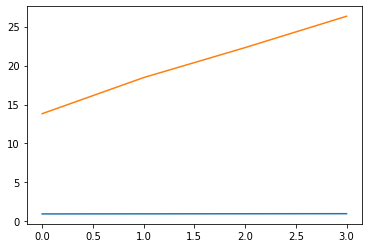

In [13]:
var = [i*0.01 for i in range(0,100)]
plt.plot(var[-len(gdp_testing):])
plt.plot(gdp_arch_preds.variance.values[-1, :])
plt.show()

In [19]:
np.sqrt(mse(gdp_df['Gross domestic product'][299: ], gdp_arch_preds))

TypeError: ignored

##GARCH

In [14]:
gdp_garch_model = arch_model(gdp_training['Gross domestic product'], vol='garch', p=5, q=5, o=5)
gdp_garch_model_results = gdp_garch_model.fit(update_freq=5)
print(gdp_garch_model_results.summary())

Iteration:      5,   Func. Count:     95,   Neg. LLF: 998.7558261469436
Iteration:     10,   Func. Count:    190,   Neg. LLF: 927.8070472562772
Iteration:     15,   Func. Count:    286,   Neg. LLF: 812.8230415774063
Iteration:     20,   Func. Count:    381,   Neg. LLF: 811.4426138572896
Iteration:     25,   Func. Count:    473,   Neg. LLF: 811.4073480092345
Optimization terminated successfully    (Exit mode 0)
            Current function value: 811.4072683443626
            Iterations: 28
            Function evaluations: 526
            Gradient evaluations: 28
                     Constant Mean - GJR-GARCH Model Results                      
Dep. Variable:     Gross domestic product   R-squared:                       0.000
Mean Model:                 Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GJR-GARCH   Log-Likelihood:               -811.407
Distribution:                      Normal   AIC:                           1656.81
Method:        

In [15]:
gdp_garch_preds = gdp_garch_model_results.forecast(horizon=len(gdp_testing))

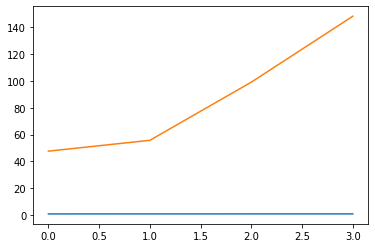

In [16]:
var = [i*0.01 for i in range(0,100)]
plt.plot(var[-len(gdp_testing):])
plt.plot(gdp_garch_preds.variance.values[-1, :])
plt.show()

## Consumer Price Index

### Evaluate Autocorrelation of Dependent Variable

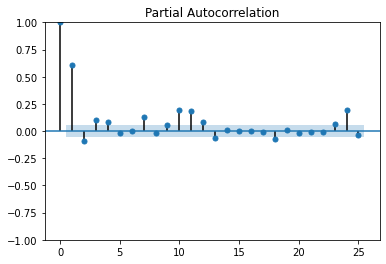

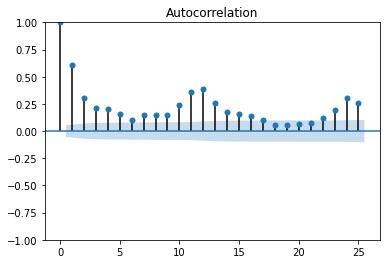

In [ ]:
pacf = plot_pacf(cpi_df['Change'], lags=25)
acf = plot_acf(cpi_df['Change'], lags=25)

In [ ]:
cpi_df['Change_2'] = cpi_df['CPI'].diff().diff()

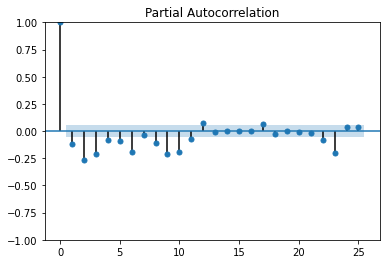

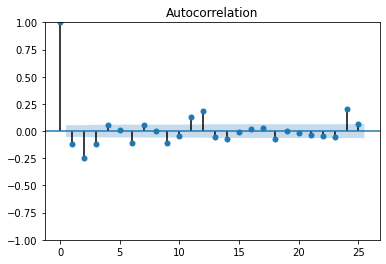

In [ ]:
pacf = plot_pacf(cpi_df['Change_2'][2:], lags=25)
acf = plot_acf(cpi_df['Change_2'][2:], lags=25)

In [ ]:
# specify size of training data

num_cpi_timepoints = len(cpi_df)
cpi_training_size = int(num_cpi_timepoints * 0.99)
cpi_training = cpi_df[:cpi_training_size]
cpi_testing = cpi_df[cpi_training_size:]

print(f"Total number of CPI Timepoints: {num_cpi_timepoints}")
print(f"Training Timepoints: {cpi_training_size}")
print(f"Testing Timepoints: {len(cpi_df) - cpi_training_size}")

# Predict up to 14 months in advance

Total number of CPI Timepoints: 1319
Training Timepoints: 1305
Testing Timepoints: 14


It should be noted that for this particular analysis the Consumer Price Index data did not satisfy the assumptions (stationarity) for Autoregressive Time Series Modeling, although we have modeled the data here out of interest.

## ARCH Model

In [ ]:
#!pip install arch

from arch import arch_model

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 907.3/907.3 KB 19.6 MB/s eta 0:00:00


In [ ]:
# define model
arch_cpi_model = arch_model(cpi_training['Change'], mean='Zero', vol='ARCH', p=4, q=4)

arch_cpi_model_fit = arch_cpi_model.fit()
# forecast the test set
arch_cpi_preds = arch_cpi_model_fit.forecast(horizon=len(cpi_testing))

Iteration:      1,   Func. Count:      7,   Neg. LLF: 119591.78851232847
Iteration:      2,   Func. Count:     14,   Neg. LLF: 57040284.34200291
Iteration:      3,   Func. Count:     21,   Neg. LLF: 57526782.32480559
Iteration:      4,   Func. Count:     28,   Neg. LLF: 78673.09897124165
Iteration:      5,   Func. Count:     35,   Neg. LLF: 98185.42315642926
Iteration:      6,   Func. Count:     42,   Neg. LLF: 37872635.84353926
Iteration:      7,   Func. Count:     49,   Neg. LLF: 35304474.41554085
Iteration:      8,   Func. Count:     56,   Neg. LLF: 37827853.89100725
Iteration:      9,   Func. Count:     63,   Neg. LLF: 24414418.314464334
Iteration:     10,   Func. Count:     70,   Neg. LLF: 6047441.057330392
Iteration:     11,   Func. Count:     77,   Neg. LLF: 158.80106223169804
Iteration:     12,   Func. Count:     84,   Neg. LLF: 36987618.34979808
Iteration:     13,   Func. Count:     91,   Neg. LLF: 136.44471723226582
Iteration:     14,   Func. Count:     97,   Neg. LLF: 136.43

/usr/local/lib/python3.8/dist-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


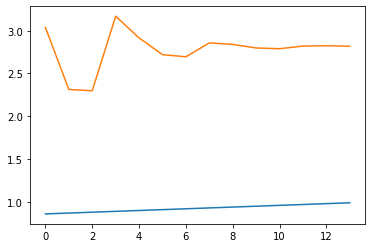

In [ ]:
var = [i*0.01 for i in range(0,100)]
plt.plot(var[-len(cpi_testing):])

# plot forecast variance
plt.plot(arch_cpi_preds.variance.values[-1, :])
plt.show()

In [ ]:
# define model
arch_cpi_model_2 = arch_model(cpi_training['Change_2'][2:], mean='Zero', vol='ARCH', p=15)

arch_cpi_model_fit_2 = arch_cpi_model_2.fit()
# forecast the test set
arch_cpi_preds_2 = arch_cpi_model_fit_2.forecast(horizon=len(cpi_testing))

Iteration:      1,   Func. Count:     18,   Neg. LLF: 224124.65379516367
Iteration:      2,   Func. Count:     36,   Neg. LLF: 55846332.201235086
Iteration:      3,   Func. Count:     54,   Neg. LLF: 14974.795783824966
Iteration:      4,   Func. Count:     72,   Neg. LLF: 3964.783245130919
Iteration:      5,   Func. Count:     90,   Neg. LLF: 413007.23916019395
Iteration:      6,   Func. Count:    108,   Neg. LLF: 115304.7475311113
Iteration:      7,   Func. Count:    126,   Neg. LLF: 151076.45644360362
Iteration:      8,   Func. Count:    144,   Neg. LLF: 2127445.302484843
Iteration:      9,   Func. Count:    162,   Neg. LLF: 2692532.340316559
Iteration:     10,   Func. Count:    180,   Neg. LLF: 4149688.7618783987
Iteration:     11,   Func. Count:    198,   Neg. LLF: 752552.1991818269
Iteration:     12,   Func. Count:    216,   Neg. LLF: 1145946.1813682467
Iteration:     13,   Func. Count:    234,   Neg. LLF: 54.5269888701381
Iteration:     14,   Func. Count:    252,   Neg. LLF: -16.

/usr/local/lib/python3.8/dist-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


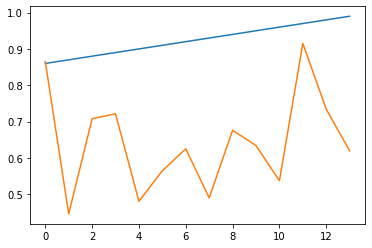

In [ ]:
var = [i*0.01 for i in range(0,100)]
plt.plot(var[-len(cpi_testing):])

# plot forecast variance
plt.plot(arch_cpi_preds_2.variance.values[-1, :])
plt.show()

In [ ]:
import seaborn as sns

In [ ]:
sns

<module 'seaborn' from '/usr/local/lib/python3.8/dist-packages/seaborn/__init__.py'>

## GARCH

In [ ]:
cpi_garch_model = arch_model(cpi_training['Change'], vol='garch', p=5, q=5, o=5)
cpi_garch_model_results = cpi_garch_model.fit(update_freq=5)
print(cpi_garch_model_results.summary())

Iteration:      5,   Func. Count:    102,   Neg. LLF: 13995.938842059393
Iteration:     10,   Func. Count:    197,   Neg. LLF: 145.10679638114402
Iteration:     15,   Func. Count:    292,   Neg. LLF: 77.50705066490912
Iteration:     20,   Func. Count:    386,   Neg. LLF: -0.9582160095480958
Iteration:     25,   Func. Count:    480,   Neg. LLF: -5.67178286155729
Optimization terminated successfully    (Exit mode 0)
            Current function value: -5.6718414904005385
            Iterations: 28
            Function evaluations: 544
            Gradient evaluations: 28
                   Constant Mean - GJR-GARCH Model Results                    
Dep. Variable:                 Change   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:                5.67184
Distribution:                  Normal   AIC:                           22.6563
Method:            Maximum Li

In [ ]:
cpi_garch_preds = cpi_garch_model_results.forecast(horizon=len(gdp_testing))

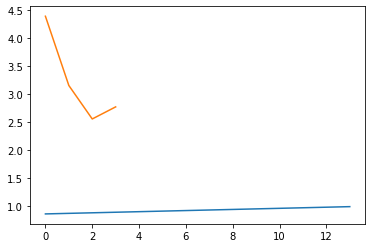

In [ ]:
var = [i*0.01 for i in range(0,100)]
plt.plot(var[-len(cpi_testing):])
plt.plot(cpi_garch_preds.variance.values[-1, :])
plt.show()